## HeartFailure data preprocessing

### Importing necessary libraries

In [1]:
import os
import sys
current_directory=os.getcwd()
parent_directory=os.path.dirname(current_directory)
sys.path.append(parent_directory)


In [2]:
import numpy as np
from library.generators.NextConvGeN import NextConvGeN


2024-01-31 11:57:56.170671: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-31 11:57:56.170691: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from fdc.fdc import feature_clustering, canberra_modified, Clustering, FDC
from fdc.clustering import *

In [4]:
import pandas as pd

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Importing data

In [6]:
data=pd.read_csv('preprocessed_cirrhosis.csv')

In [7]:
np.random.seed(42)
data=data.sample(frac=1)

In [8]:
data.drop_duplicates(inplace=True, ignore_index=True)

In [9]:
data['Stage'].value_counts()

3.0    156
4.0    148
2.0     93
1.0     21
Name: Stage, dtype: int64

In [10]:
data['Stage'].replace([1,2,3,4],[0,1,2,3], inplace=True)

In [11]:
output_file_path=os.path.join(parent_directory,"PreprocessedDatasets/LiverCirrhosis.csv")
data.to_csv(output_file_path, index=False)

In [12]:
data.drop(['Stage'],axis=1, inplace=True)

In [13]:
np.random.seed(42)
data=data.sample(frac=1)

In [14]:
values=['N_Days','Age','Bilirubin','Cholesterol','Albumin','Copper','Alk_Phos',
        'SGOT','Tryglicerides','Platelets','Prothrombin','Ascites','Hepatomegaly','Spiders','Edema',
       'Status','Drug','Sex']

In [15]:
data=data[values]

### UMAP on entire data

In [16]:
from fdc.fdc import feature_clustering

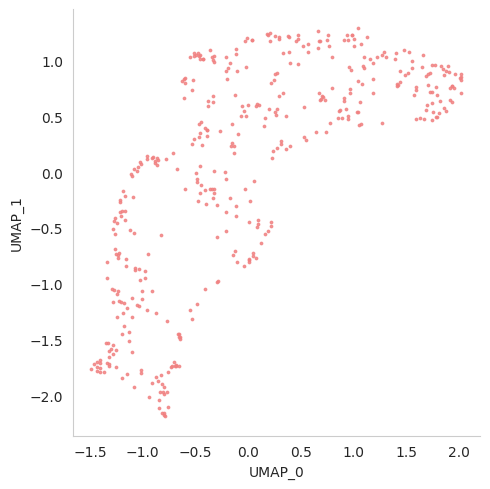

In [17]:
np.random.seed(42)
umap_emb=feature_clustering(30,0.1,'euclidean',data,True)

### Feature-type Distributed Clustering (FDC)

In [18]:
cont_list=['N_Days','Age','Bilirubin','Cholesterol','Albumin','Copper','Alk_Phos','SGOT','Tryglicerides','Platelets','Prothrombin']

ord_list=['Ascites','Hepatomegaly','Spiders','Edema']

nom_list=['Status','Drug','Sex']

target = ['Stage']


In [19]:
output_file_path=os.path.join(parent_directory,"PreprocessedDatasets/LiverCirrhosis.json")

In [20]:
import json

features = {
    "cont_list": cont_list,
    "nom_list": nom_list,
    "ord_list": ord_list,
    "target": target
}

with open(output_file_path, "w") as json_file:
    json.dump(features, json_file)

FDC.normalize (init): 0.00001 / 0.000s


FDC.normalize (clustering CONT): 1.59402 / 1.594s


FDC.normalize (clustering ORD): 4.00527 / 5.599s


FDC.normalize (clustering NOM): 4.09241 / 9.692s
FDC.normalize (concat): 0.00006 / 9.692s


FDC.normalize (umap 5 -> 2): 1.52798 / 11.220s
FDC.normalize (array -> DataFrame): 0.00025 / 11.220s


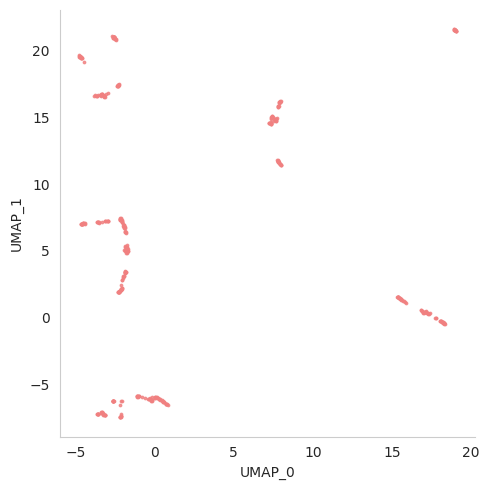

FDC.normalize (plotting): 0.39527 / 11.615s
FDC.normalize (array -> DataFrame): 0.00017 / 11.615s
FDC.normalize (total): 0.00001 / 11.615s


In [21]:
from fdc.fdc import feature_clustering, canberra_modified, Clustering, FDC

np.random.seed(42)

fdc = FDC(clustering_cont=Clustering('euclidean',30,0.01)
          , clustering_ord=Clustering(canberra_modified,30,0.01)
          , clustering_nom=Clustering('hamming',30,0.01)
          , visual=True
          , use_pandas_output=True
          , with_2d_embedding=True
          )

fdc.selectFeatures(continueous=cont_list, nomial=nom_list, ordinal=ord_list)

FDC_emb_high,FDC_emb_low = fdc.normalize(data,cont_list=cont_list, nom_list=nom_list, ord_list=ord_list,
                  with_2d_embedding=True,
                  visual=True)

### Clustering using K-means

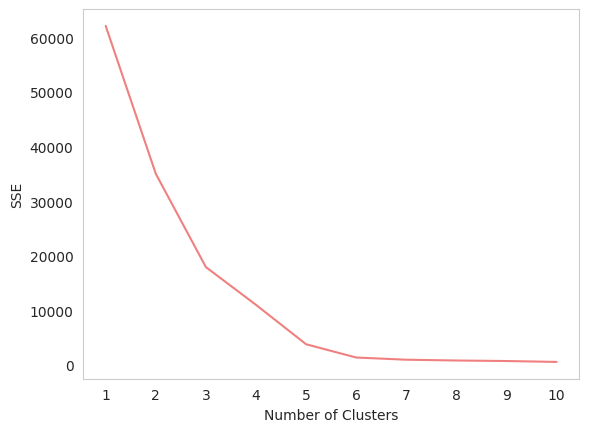

In [22]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(FDC_emb_low)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [23]:
def find_optimal_cluster(FDC_emb_low):
    silhouette_scores = []

    for n_clusters in list(range(2, 9)):
        km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=100, random_state=42)

        km.fit(FDC_emb_low)

        labels = km.labels_

        # Compute the silhouette score
        silhouette_avg = silhouette_score(FDC_emb_low, labels)
        silhouette_scores.append(silhouette_avg)
    return silhouette_scores

In [24]:
find_optimal_cluster(FDC_emb_low)

[0.4540804, 0.5927589, 0.6602747, 0.77670383, 0.82607114, 0.7806594, 0.764576]

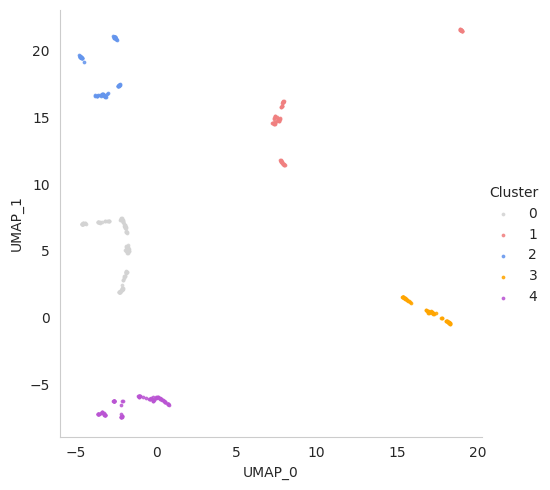

In [25]:
from fdc.clustering import *
np.random.seed(42)
clustering=Clustering(FDC_emb_low,FDC_emb_low,True)
cluster_list,cluster_counts=clustering.K_means(5)

In [26]:
cluster_counts

array([119,  79,  69,  62,  89])

In [27]:
data['Target']=cluster_list

In [28]:
output_file_path=os.path.join(parent_directory,"PreprocessedDatasets/SSLiverCirrhosis.csv")
data.to_csv(output_file_path, index=False)